In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
from torchvision import transforms
from albumentations import Compose, Normalize, RandomCrop, HorizontalFlip, ShiftScaleRotate, HueSaturationValue
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models
!pip install torchmetrics
from torchmetrics import AUROC
import io
import matplotlib.pyplot as plt
import time
import copy
import albumentations as A
import torch.nn.functional as F
from sklearn.model_selection import train_test_split


from glob import glob
from tqdm import tqdm

import warnings
from sklearn.metrics import f1_score,accuracy_score,recall_score,roc_auc_score,roc_curve

In [2]:
from transformers import SegformerModel, SegformerConfig

import torch

import torch.nn as nn

from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

from PIL import Image

import requests

from transformers import SegformerPreTrainedModel, SegformerForSemanticSegmentation

from transformers import SegformerModel, SegformerConfig

### Decoding RLEs into masks for training

In [3]:
def decode_rle_to_mask(rle, height, width, viz=False):
    '''
    rle : run-length as string formated (start value, count)
    height : height of the mask 
    width : width of the mask
    returns binary mask
    '''
    rle = np.array(rle.split(' ')).reshape(-1, 2)
    mask = np.zeros((height*width, 1))
    if viz:
        color = np.random.rand(1)
    else:
        color = 1
    for i in rle:
        mask[int(i[0]):int(i[0])+int(i[1])] = color

    return mask.reshape(height, width)

In [4]:
def read_img_label(img_name):
    imagePath = os.path.sep.join(['/kaggle/input/Multiclass-segmentation/TrainImages', img_name+str('.jpg')])
    #reading rgb image from path
    img = cv.imread(imagePath)
    #resizing image so all images can have the same size
    img = cv.resize(img,img_shape)
    #get masks of the image from train csv file
    masks=train_df.loc[train_df.ImageName==img_name]
    #loobing over masks to create one channel label img
    #mask------> [name,width,height,class_num,encodings]
    combined_masks=0
    for _, mask in masks.iterrows():
        combined_masks=combined_masks+decode_rle_to_mask(mask[4],int(mask[1]), int(mask[2]))*int(mask[3])
    #resizing label to match new image size then taking the integer value  
    combined_masks=cv.resize(combined_masks,img_shape, interpolation = cv2.INTER_NEAREST).astype('uint8')   
    #return both image and label
    return img,combined_masks

In [5]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, names, img_dir, transform=None):
        self.names = names
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        image,mask = read_img_label( self.names[idx])
        sample = {'image': image, 'mask': mask}

        if self.transform:
            sample = self.transform(sample)
        return sample

In [6]:
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b4-finetuned-ade-512-512")
def transform(sample):
    data_transforms = Compose([                  
                        Normalize(),
                        ToTensorV2()
                    ])
    sample['image']= sample['image'].astype("float32")
    sample = data_transforms(**sample)
    sample['image']=feature_extractor(sample['image'], return_tensors="pt")
    sample['image']=sample['image']['pixel_values']    
    return sample

/opt/conda/lib/python3.7/site-packages/transformers/models/segformer/feature_extraction_segformer.py:31: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/transformers/models/segformer/image_processing_segformer.py:105: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  FutureWarning,


In [7]:
#read train csv file in a dataframe
train_df = pd.read_csv("/kaggle/input/Multiclass-segmentation/train.csv")
# array containing names of images
train_img_names = train_df["ImageName"].unique()
train_names, test_names = train_test_split(train_img_names, test_size=0.2, random_state=42)

#choose width and hight for resizing
img_shape=(224,224)
width=224
height=224
batch_size=4
#colors for better visualization of labels
colors={0:(0,0,0),
       1:(0,255,255),
        2:(255,0,0),
        3:(0,255,0),
        4:(0,0,255),
        -1:(0,0,0)
       }
train_dataset = CustomDataset(train_names,
                                    img_dir='/kaggle/input/Multiclass-segmentation/TrainImages',transform=transform)
test_dataset = CustomDataset(test_names,
                                    img_dir='/kaggle/input/Multiclass-segmentation/TrainImages',transform=transform)

# Notes: add more functions inside Compose for increase the segmentation. Read the documentation 

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [9]:
dataloaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=2),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
                                            }

In [10]:
ex_image_train = next(iter(dataloaders['train']))['image']# should be 8 * 224 * 224 * 3 because number of batches = 8
ex_mask_train = next(iter(dataloaders['train']))['mask']# should be 8 * 224 * 224 * 1 because number of batches = 8
print(ex_image_train.shape)

#Next iter just gives Example of 8 images 

torch.Size([4, 1, 3, 512, 512])


In [11]:
ex_image_test = next(iter(dataloaders['test']))['image']# should be 8 * 224 * 224 * 3 because number of batches = 8
ex_mask_test = next(iter(dataloaders['test']))['mask']# should be 8 * 224 * 224 * 1 because number of batches = 8

print(ex_mask_test.shape)





torch.Size([4, 224, 224])


[0 1 2 3 4]


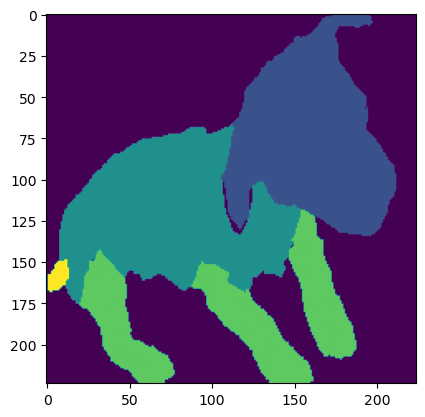

In [14]:
plt.imshow(ex_mask_train[1])
print(np.unique(ex_mask_train))


next(iter()) gives you one example from itererable object it is equals = i when you loop like ig you looped on 
dataloaders: 

    For i in dataloaders:
        ex = i['train']['image']
        
        
So, next(iter()) just gives you one i, but in case your data have number of images > number of batch size(8 in our case). the iteration will iterate until number of images will be finished  

In [15]:
#!pip install transformers

# Custom Segformer

In [16]:
#!pip install transformers

In [17]:
class CustomSegFormer2(SegformerPreTrainedModel):
    def __init__(self, config, in_channel, n_classes=5):
        super().__init__(config)
        self.segformer = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b4-finetuned-ade-512-512", ignore_mismatched_sizes=True)
        self.logits_outputs = nn.Conv2d(in_channel, out_channels=n_classes, kernel_size=1, stride=1, padding=0)
        

    def forward(self, pixel_values):
        # forward to get raw logits
        pixel_values=torch.squeeze(pixel_values, dim=1)
        outputs = self.segformer(pixel_values) # what's the number of output channels?
        logits_outputs = self.logits_outputs(outputs[0])
        # next, do whatever you want with the logits to compute loss
        # upsample logits here; the predicted distance map is also needed to unsampled, right?
        upsampled_logits = nn.functional.interpolate(logits_outputs, size=img_shape, mode="bilinear", align_corners=False)
        # calculate losses for logits and distance map respectively and sum the two losses
        
        return  upsampled_logits

In [18]:
from transformers import SegformerModel, SegformerConfig
import torch
import numpy as np

configuration = SegformerConfig()
model=CustomSegFormer2(configuration,in_channel=150)



# Output note
for the loss, put the logits and the GT directly, 
But before the argmax function for calculting IOU you have first to enter the logits into softmax function: 
ex -- > Argmax(Softmax(Logits))

In [19]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch



  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-4_8_20oz
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-4_8_20oz
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 8523324c116dcf7be6bddb73bf4eb1779ef6e611
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.2-py3-none-any.whl size=106735 sha256=ebe8cbfcc4a592d90af53683bbbc2268bc5800080f65b180e93ae9c9a388f521
  Stored in directory: /tmp/pip-ephem-wheel-cache-rwrlardf/wheels/fa/c5/a8/1e8af6cb04a0974db8a4a156ebd2fdd1d99ad2558d3fce49d4
  Created wheel for efficientnet-pyt

In [20]:
import segmentation_models_pytorch as smp
dice_loss=smp.losses.DiceLoss('multiclass')
def iou(output, target):
    output=F.softmax(output, dim=1)
    output = torch.argmax(output, dim=1)
    tp, fp, fn, tn = smp.metrics.get_stats(output, target, mode='multiclass',num_classes=5)
    return smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")



In [21]:
#model=smp.UnetPlusPlus(encoder_name='efficientnet-b0', encoder_weights='imagenet', decoder_use_batchnorm=True,in_channels=3, classes=5)

In [22]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer):
    train_losses = []
    test_losses = []
    val_iou = []; 
    train_iou = []; 
    min_loss = np.inf
    max_val_iou_score=0
    increase = 0 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(train_loader):
            #training phase
            image_tiles = data['image']
            mask_tiles = data['mask']


            image = image_tiles.to(device)
            mask = mask_tiles.type(torch.LongTensor).to(device)
            #forward
            output = model(image).to(device)
            #loss = criterion(output, mask.type(torch.LongTensor).to(device)).requires_grad_()
            loss =criterion(output, mask)
            #evaluation metrics
            iou_score += iou(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            running_loss += loss.item()
            
            model.eval()
            test_loss = 0
            val_iou_score = 0
        #validation loop
        with torch.no_grad():

            for i, data in enumerate(val_loader):
                image_tiles = data['image']
                mask_tiles = data['mask']

                image = image_tiles.to(device); mask = mask_tiles.type(torch.LongTensor).to(device);
                output = model(image)
                #evaluation metrics
                val_iou_score +=  iou(output, mask)
                #loss
                loss = criterion(output, mask)                                  
                test_loss += loss.item()

        #calculatio mean for each batch
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(val_loader))


        if max_val_iou_score < (val_iou_score/len(val_loader)):
            print('val_iou_increased.. {:.3f} >> {:.3f} '.format(max_val_iou_score, (val_iou_score/len(val_loader))))
            max_val_iou_score =  (val_iou_score/len(val_loader))
            increase += 1
            not_improve=0
            if increase % 5 == 0:
                print('saving model...')
                torch.save(model, 'segformer-{:.3f}.pt'.format(val_iou_score/len(val_loader)))

        else :
            not_improve += 1
            if not_improve == 7:
                print('Loss not decrease for 7 times, Stop Training')
                break


        #iou
        val_iou.append(val_iou_score/len(val_loader))
        train_iou.append(iou_score/len(train_loader))
        print("Epoch:{}/{}..".format(e+1, epochs),
              "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
              "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
              "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
              "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
              "Time: {:.2f}m".format((time.time()-since)/60))

    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               }
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history


In [23]:
epoch = 5
lr = 0.00006
criterion  =dice_loss
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
history = fit(epoch, model, dataloaders['train'], dataloaders['test'], criterion, optimizer)

val_iou_increased.. 0.000 >> 0.786 
Epoch:1/5.. Train Loss: 0.528.. Val Loss: 0.400.. Train mIoU:0.672.. Val mIoU: 0.786.. Time: 12.44m
val_iou_increased.. 0.786 >> 0.796 
Epoch:2/5.. Train Loss: 0.366.. Val Loss: 0.369.. Train mIoU:0.796.. Val mIoU: 0.796.. Time: 12.53m
val_iou_increased.. 0.796 >> 0.805 
Epoch:3/5.. Train Loss: 0.316.. Val Loss: 0.355.. Train mIoU:0.831.. Val mIoU: 0.805.. Time: 12.54m
Epoch:4/5.. Train Loss: 0.284.. Val Loss: 0.365.. Train mIoU:0.852.. Val mIoU: 0.805.. Time: 12.52m
Epoch:5/5.. Train Loss: 0.260.. Val Loss: 0.373.. Train mIoU:0.864.. Val mIoU: 0.803.. Time: 12.50m
Total time: 62.52 m


In [24]:
torch.save(model, 'segformer.pt')
#model=model.load('segformer.pt')


In [25]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    


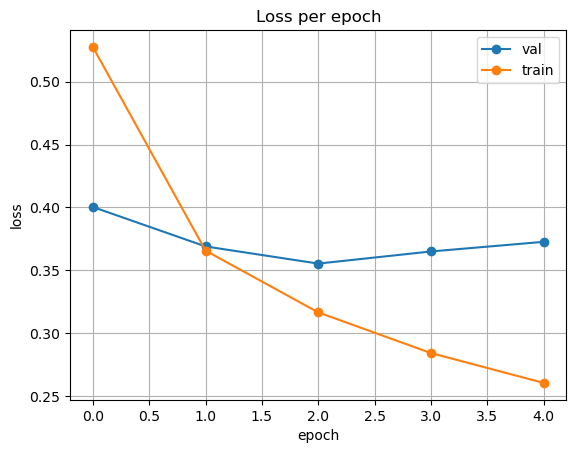

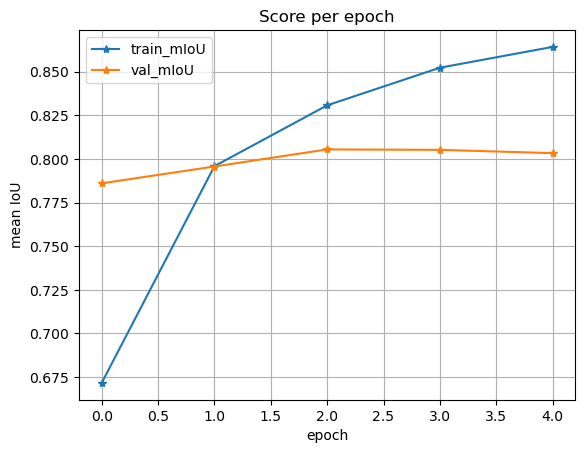

In [26]:
plot_loss(history)
plot_score(history)


(3, 224, 224)


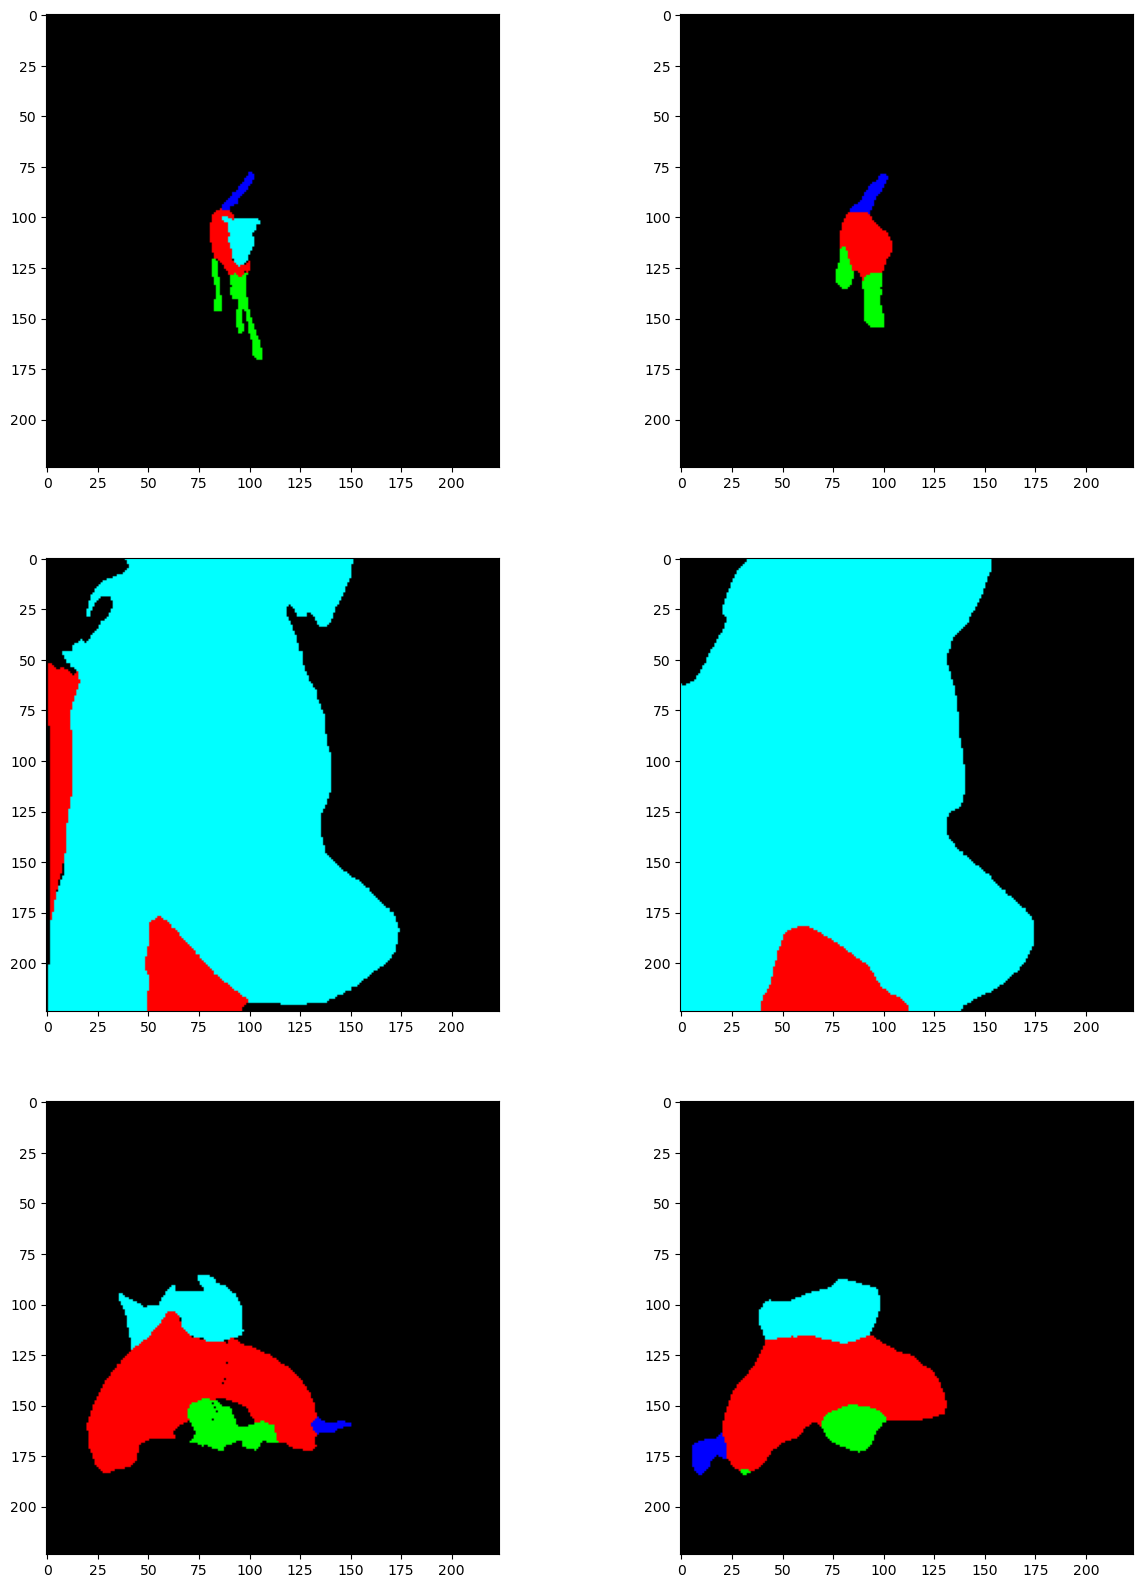

In [27]:
data= next(iter(dataloaders['train']))
image_tiles = data['image']
mask_tiles = data['mask']
image = image_tiles.to(device)
output = model(image)
output=F.softmax(output, dim=1)
output = torch.argmax(output, dim=1)
output =output.cpu().detach().numpy()[0:3]
print(output.shape)
tmp = np.zeros([len(output),224, 224, 3])
tmp2 = np.zeros([len(output),224,224, 3])
for sample in range(len(output)):
    mask=mask_tiles[sample].numpy()
    pred=output[sample]
    for row in range(224):
        for col in range(224):
            tmp[sample,row, col, :] = colors[pred[row, col]]
            tmp2[sample,row, col,:] = colors[mask[row, col]]
            tmp = tmp.astype('uint8')
            tmp2 = tmp2.astype('uint8')
    
plt.figure(figsize=(15, 20))
for i in range(len(output)):
    plt.subplot(len(output), 2, i*2+1)
    plt.imshow(tmp2[i])
    plt.subplot(len(output), 2, i*2+2)
    plt.imshow(tmp[i])

(3, 224, 224)


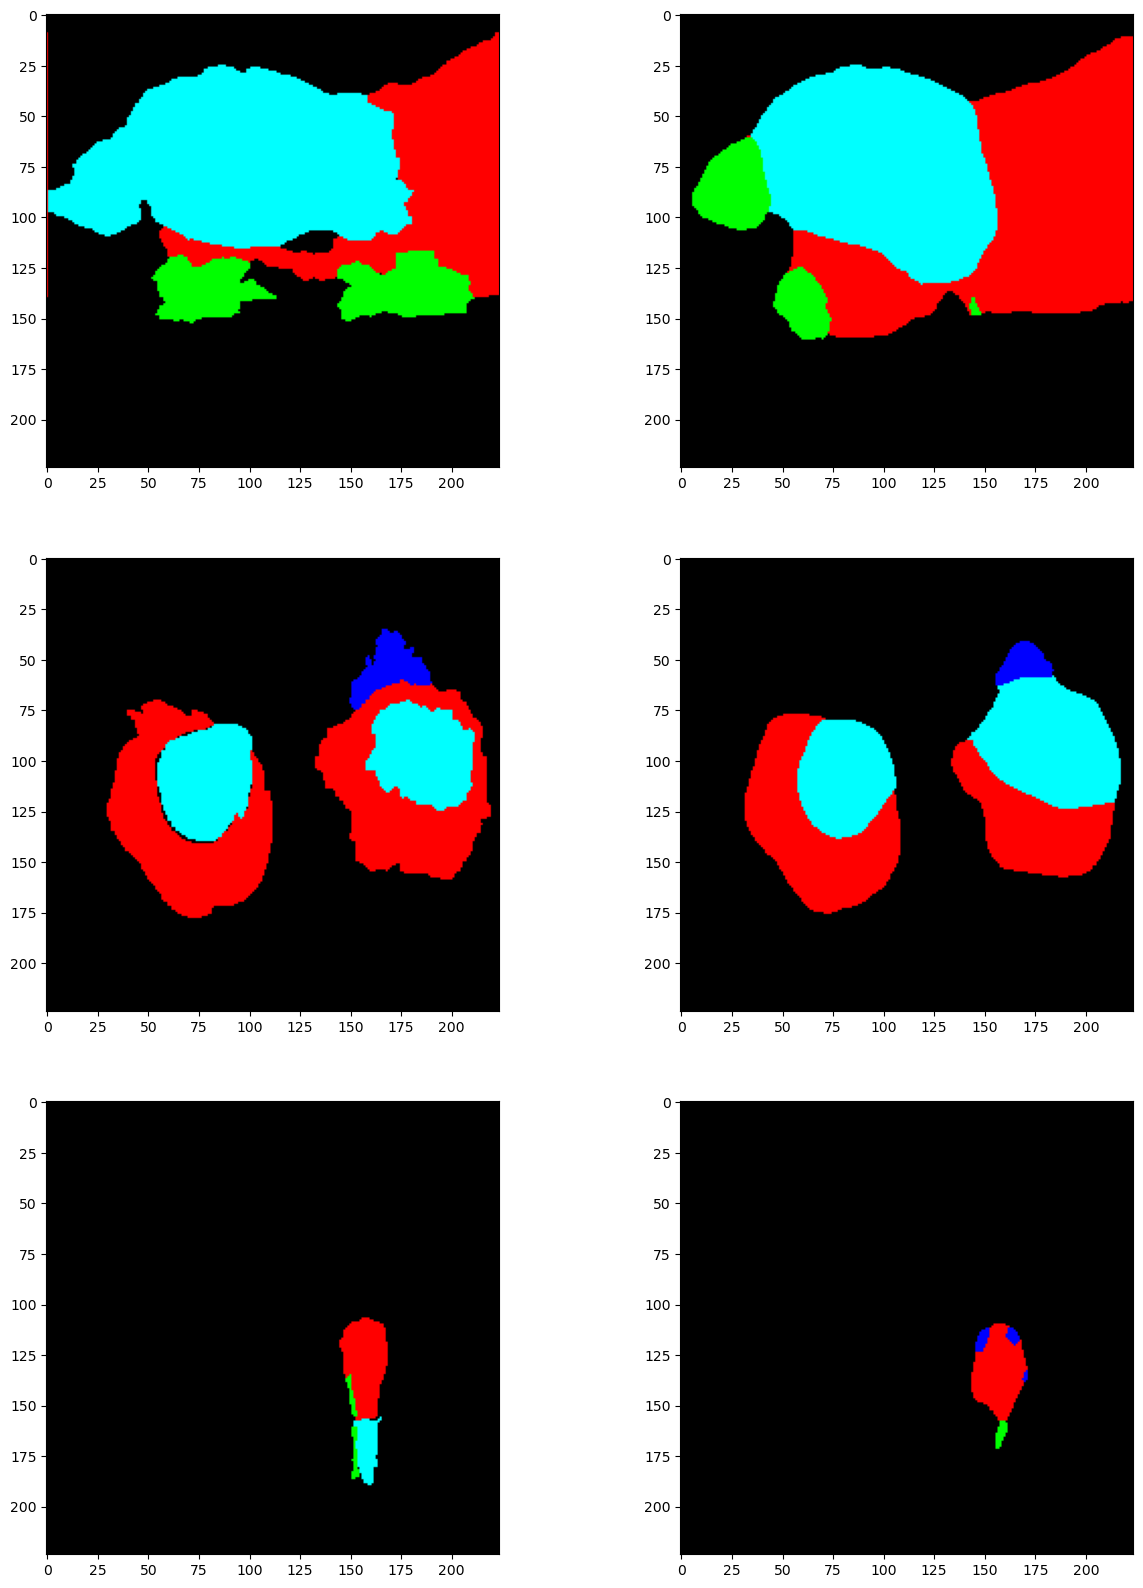

In [28]:
data= next(iter(dataloaders['test']))
image_tiles = data['image']
mask_tiles = data['mask']
image = image_tiles.to(device)
output = model(image)
output=F.softmax(output, dim=1)
output = torch.argmax(output, dim=1)
output =output.cpu().detach().numpy()[0:3]
print(output.shape)
tmp = np.zeros([len(output),224, 224, 3])
tmp2 = np.zeros([len(output),224,224, 3])
for sample in range(len(output)):
    mask=mask_tiles[sample].numpy()
    pred=output[sample]
    for row in range(224):
        for col in range(224):
            tmp[sample,row, col, :] = colors[pred[row, col]]
            tmp2[sample,row, col,:] = colors[mask[row, col]]
            tmp = tmp.astype('uint8')
            tmp2 = tmp2.astype('uint8')
    
plt.figure(figsize=(15, 20))
for i in range(len(output)):
    plt.subplot(len(output), 2, i*2+1)
    plt.imshow(tmp2[i])
    plt.subplot(len(output), 2, i*2+2)
    plt.imshow(tmp[i])

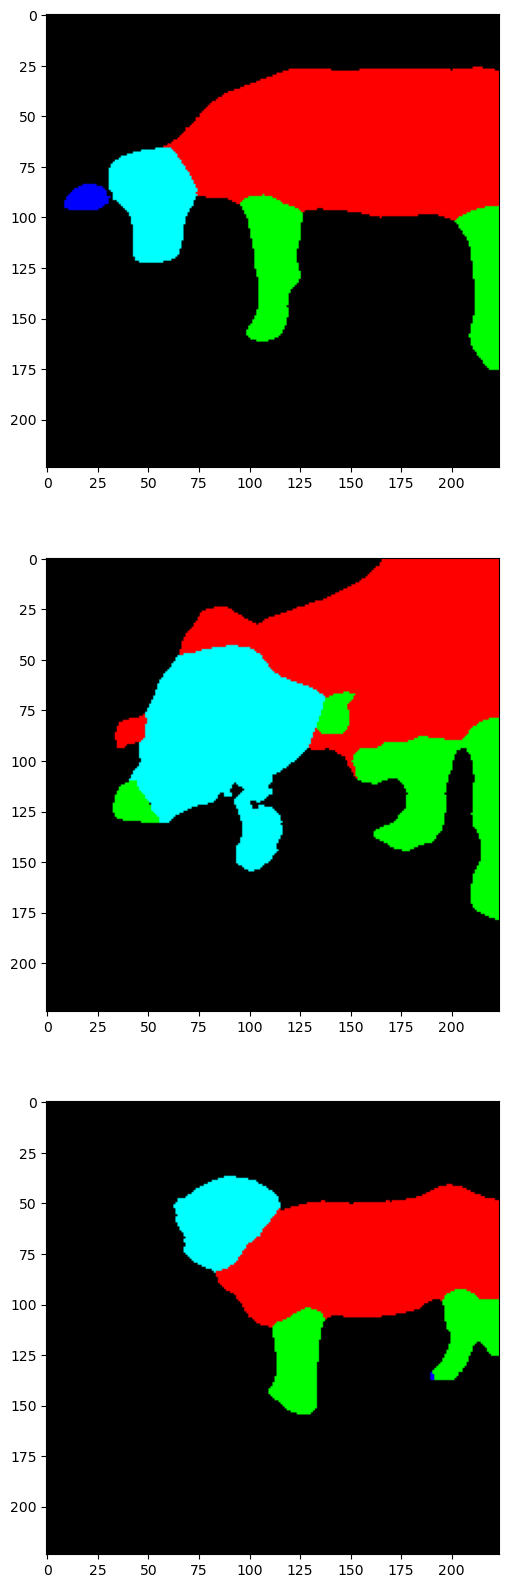

In [30]:
tmp = np.zeros([3,224, 224, 3])
for i in range(1,4):
    imagePath='/kaggle/input/Multiclass-segmentation/TestImages/2'+str(i+5)+'.jpg'
    test=cv.imread(imagePath)
    test = cv.resize(test,(224,224))
    test=torch.tensor(test,dtype=torch.float32)
    test=feature_extractor(test, return_tensors="pt")
    test = test["pixel_values"].to(device)
    output = model(test)
    output=F.softmax(output, dim=1)
    output = torch.argmax(output, dim=1)
    output =output.cpu().detach().numpy()
    for row in range(224):
        for col in range(224):
            tmp[i-1,row, col, :] = colors[output[0,row, col]]
tmp = tmp.astype('uint8')
    
plt.figure(figsize=(10, 20))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.imshow(tmp[i])

# Now what is next: 
I gave you some hints, now you can start from here and open any kaggle competition to see how to run training pipline for segmentation, it is supposed also to know how to run training segmetnation pipline if you have a look on any kaggle the classification pipline. Just be comfort with dataloader variable I llustriate in the previous cells and actually they repressents


# if you have any question send to me i will be able to reply from 6:00 pm